<h3>1. Import Dependecies</h3>

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

<h3>2. Keypoints using MP Holistic</h3>


In [3]:
mp_holistic = mp.solutions.holistic # Holistic Model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # Color Conversion
    image.flags.writeable=False
    results = model.process(image)                # Make Prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) # Color Conversion
    return image,results

In [7]:
# standard function
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [9]:
# styled function
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [ ]:
cap = cv2.VideoCapture(0)

#Access mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read() #Read the frame
    
        #Detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        #Landmarks
        draw_styled_landmarks(image, results)
          
        cv2.imshow('OpenCV', image) #show it on screen
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [13]:
'''
The face and hand landmarks will return no values if nothing is detected

The pose model will return landmarks but the visibility value inside of each landmark will be low.
'''
print(f'Face Landmarks: {len(results.face_landmarks.landmark)}, Pose Landmarks: {len(results.pose_landmarks.landmark)}')
# print(f'Left Hand Landmarks: {len(results.left_hand_landmarks.landmark)}, Right Hand Landmarks: {len(results.right_hand_landmarks.landmark)}')

Face Landmarks: 468, Pose Landmarks: 33


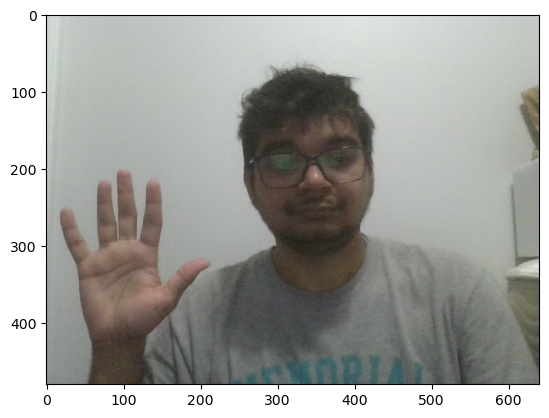

In [15]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [17]:
draw_landmarks(frame, results)

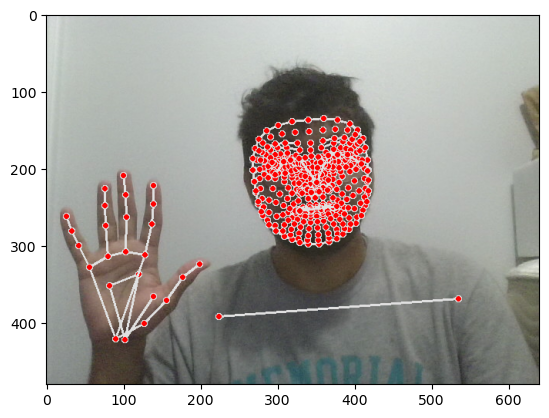

In [19]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

<h3> 3. Extract keypoint values</h3>

In [ ]:
results.pose_landmarks

In [23]:
pose_landmarks_np = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
print(f'Length of the landmarks : {len(pose_landmarks_np)} and shape is {pose_landmarks_np.shape}')

Length of the landmarks : 132 and shape is (132,)


In [27]:
#try for left hand
print(f'The o/p of the hand landmarks: {results.left_hand_landmarks}')
rh_landmarks_np = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
print(f'Length of the landmarks : {len(rh_landmarks_np)} and shape is {rh_landmarks_np.shape}')

The o/p of the hand landmarks: None
Length of the landmarks : 63 and shape is (63,)


In [ ]:
#try for right hand
print(f'The o/p of the hand landmarks: {results.right_hand_landmarks}')
rh_landmarks_np = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3) 
print(f'Length of the landmarks : {len(rh_landmarks_np)} and shape is {rh_landmarks_np.shape}')

In [31]:
#Extracting the keypoints
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)  
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3) 
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh,rh])

In [33]:
print(f'Final extract keypoints are: {len(extract_keypoints(results))}')

Final extract keypoints are: 1662


<h3> 4. Setup for Collection</h3>

In [35]:
#Path for exported_data; numpy arrays
DATA_PATH = os.path.join('MP_DATA')

#Actions that we try to detect
# actions = np.array(['Hello','Dankz','i love you','Super','Namaste_Vanakkam','Okay Dude'])
actions = np.array(['Hello','Dankz'])

no_sequences = 30  # 30 number of videos of data
sequence_length = 30 #each of 30frames per sec in length

In [123]:
actions_new = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'])

In [140]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
            pass

In [ ]:
cap = cv2.VideoCapture(0)
# Ready mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop the actions
    for action in actions:
        # Loop through sequences aka video
        for sequence in range(no_sequences):
            # Loop through video length 
            for frame_num in range(sequence_length):
                
                # Read the feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                #collection logic with breaks
                if frame_num ==  0:         #0th frame
                    cv2.putText(image,'STARTING COLLECTION',(120,200),
                           cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),4,cv2.LINE_AA)
                    cv2.putText(image,'Collecting frames for {} Video number{}'.format(action,sequence),(15,12),
                           cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),2,cv2.LINE_AA)
                    cv2.waitKey(1000)
                else:
                    cv2.putText(image,'Collecting frames for {} Video Number{}'.format(action,sequence),(15,12),
                             cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),2,cv2.LINE_AA)

                #export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH,action,str(sequence),str(frame_num))
                np.save(npy_path,keypoints)

                # Show to screen
                cv2.imshow('Collecting the data', image)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

<h3>6. Preprocess the data and create lables and features</h3>

In [37]:
#
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [39]:
label_map = {label:num for num,label in enumerate(actions)}
label_map

{'Hello': 0, 'Dankz': 1}

In [41]:
sequences,labels = [],[]
for action in actions:
  for sequence in range(no_sequences):
    window = []
    for frame_num in range(sequence_length):
      res = np.load(os.path.join(DATA_PATH,action,str(sequence),"{}.npy".format(frame_num)))
      window.append(res)
    sequences.append(window)
    labels.append(label_map[action])

In [43]:
np.array(sequences).shape

(60, 30, 1662)

In [45]:
np.array(labels).shape

(60,)

In [47]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [49]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.05)

In [51]:
print(f'shapes of X-train: {X_train.shape}, Y-train: {X_test.shape}, Y-train: {y_train.shape}, Y-test: {y_test.shape} ')

shapes of X-train: (57, 30, 1662), Y-train: (3, 30, 1662), Y-train: (57, 2), Y-test: (3, 2) 


<h3>7. Train and test the LSTM Neural Network</h3>

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [55]:
model = Sequential()
model.add(LSTM(64,return_sequences=True,activation='relu', input_shape=(30,1662)))   #30frames, 1662 keypoints
model.add(LSTM(128,return_sequences=True,activation='relu'))
model.add(LSTM(64,return_sequences=False,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(actions.shape[0],activation='softmax'))

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy']) #for multi class use categ cross entropy

C:\Users\abhis\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [195]:
#EXAMPLE (python -m tensorboard.main --logdir=logs/) to check while model.fit is running
# python -m tensorboard.main --logdir='your log dir'

In [ ]:
model.fit(X_train,y_train,epochs=1500,callbacks=[tb_callback])

In [59]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,789,928 (6.83 MB)

 Trainable params: 596,642 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,286 (4.55 MB)

<h3>8. Making predictions</h3>

In [61]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


In [63]:
print(f'This means that {res[0]} and we get the max of it {np.argmax(res[0])} is same as per our data is {actions[np.argmax(res[0])]} which should be same as y_test {actions[np.argmax(y_test[0])]}')

This means that [0.56758285 0.4324171 ] and we get the max of it 0 is same as per our data is Hello which should be same as y_test Dankz


<h3>9. Saving Weights</h3>

In [65]:
model.save('actions.h5')

<h3>10. Evaluation using confusion matrix</h3>

In [67]:
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix

In [69]:
yhat = model.predict(X_test)
ytrue= np.argmax(y_test,axis=1).tolist()
yhat = np.argmax(yhat,axis=1).tolist()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [71]:
multilabel_confusion_matrix(ytrue,yhat)

array([[[1, 2],
        [0, 0]],

       [[0, 0],
        [2, 1]]], dtype=int64)

In [73]:
accuracy_score(ytrue,yhat)

0.3333333333333333

<h3>11. Test in real time</h3>

In [90]:
# Update the colors list with two more colors
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 0),(255,165,0)]

# Function to visualize probabilities
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
    return output_frame

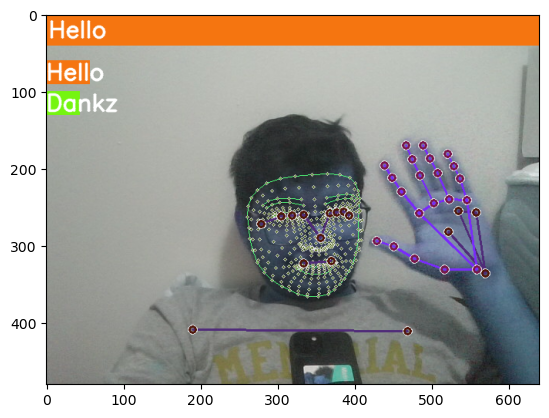

In [100]:
plt.imshow(prob_viz(res, actions, image, colors))

In [119]:
sequence=[]
sentence=[]
predictions=[]
threshold = 0.4

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret,frame = cap.read()

        image,results = mediapipe_detection(frame,holistic)
        print(results)

        draw_styled_landmarks(image,results)

        #Prediction logic code
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence,axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))


        #Viz logic
        if np.unique(predictions[-10:])[0]==np.argmax(res): 
            if res[np.argmax(res)] > threshold:
                  if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                  else:
                      sentence.append(actions[np.argmax(res)])
       
        if len(sentence) > 5:
          sentence = sentence[-5:]

        cv2.rectangle(image,(0,0),(640,40),(245,117,16),-1)
        cv2.putText(image, ''.join(sentence),(3,30),
                  cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
        image = prob_viz(res,actions,image,colors)
        cv2.imshow('OpenCV Feed',image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF ==ord('q'):
          break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>


IndexError: index 0 is out of bounds for axis 0 with size 0

In [121]:
cap.release()
cv2.destroyAllWindows()